In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import os
import csv

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, cross_val_predict
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.gridspec as gridspec

from deforestutils import *

from joblib import dump, load
from joblib import Parallel, delayed




  0%|          | 0/10 [00:00<?, ?it/s]

Set to create new indices for test train split and cross validation
Starting fit for 2004
Files setup.
Read in data for 2004
Years in data: [2004 2005 2006 2007]
Number of rows in data: (665048, 216)
Test set pct of data: 30.002044965175443
New test/train indices generated and saved in TestTrainSplit


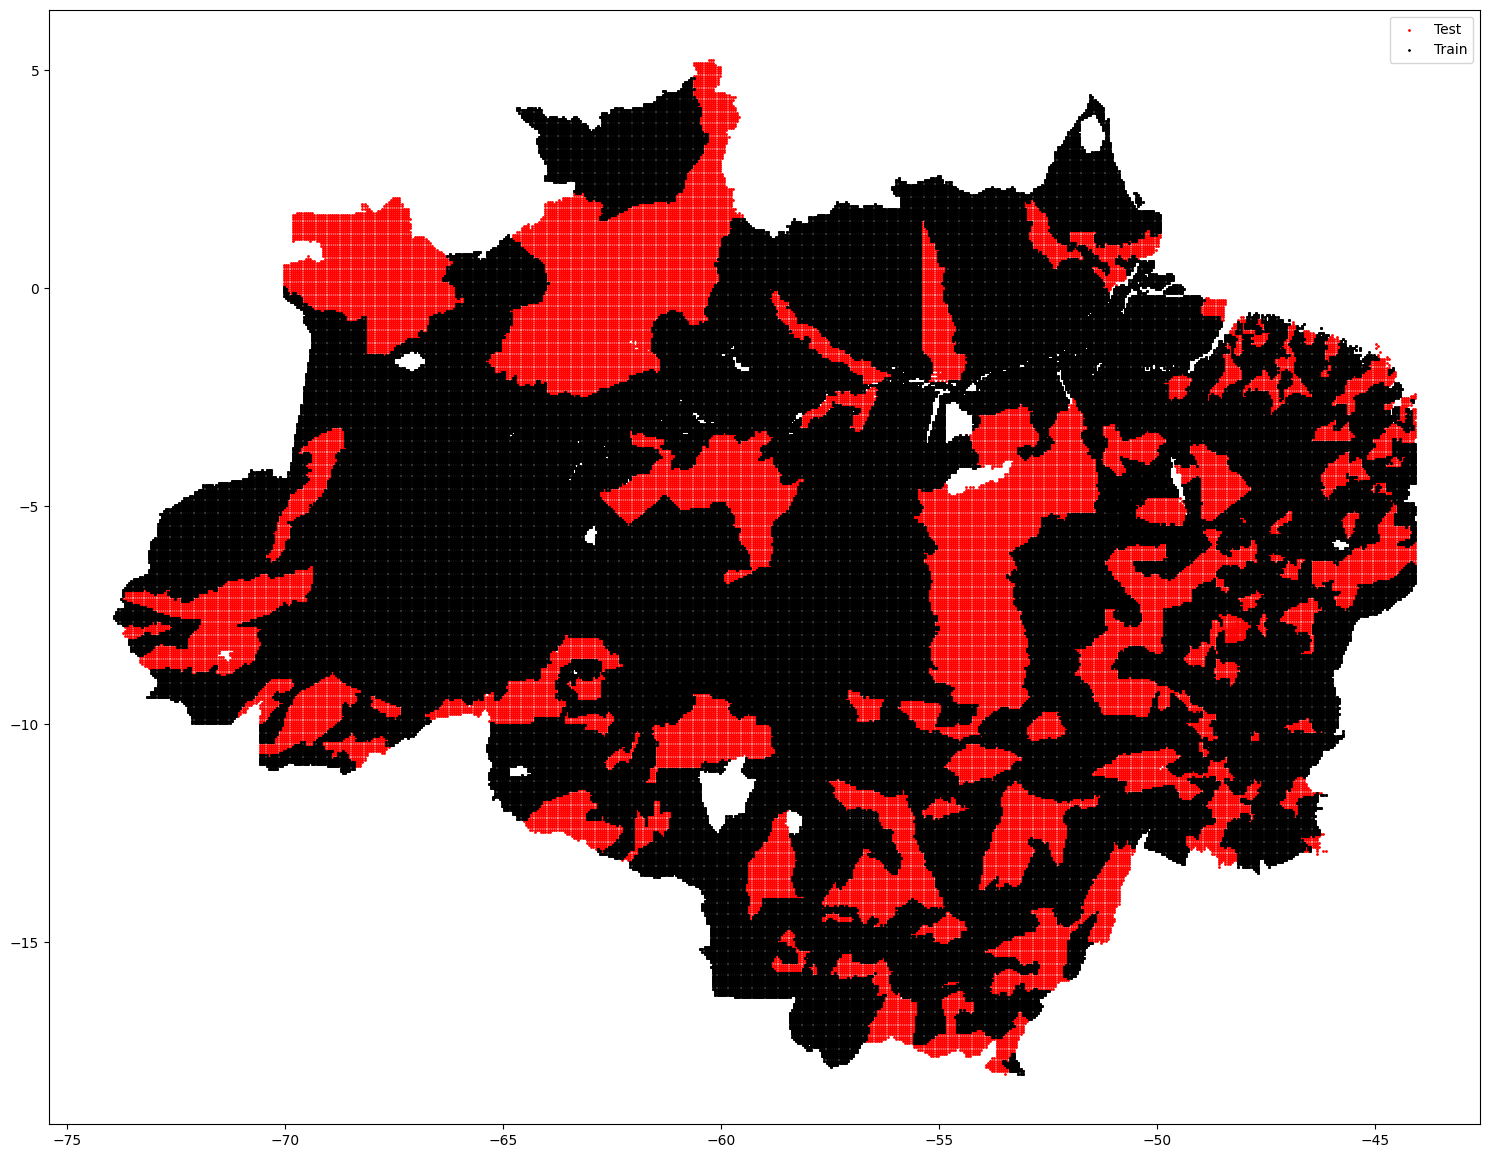

New cross validation indices generated and read in


/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  20.4s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  20.8s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  20.9s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  20.9s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,)

X does not have valid feature names, but StandardScaler was fitted with feature names
Using 349862 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


: 

: 

In [2]:
first_time = True

for this_start_year in tqdm([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]):
    SUBSET = False
    SUBSET_SIZE = 100000

    if first_time: 
        NEW_INDICES = True
        NEW_CV_INDICES = True
        #first_time = False
        print('Set to create new indices for test train split and cross validation')
    else: 
        NEW_INDICES = False
        NEW_CV_INDICES = False
        print('Reading previous iteration test train split indices and cross validation indices')
    

    PLOT_ENTIRE_AREA = True
    PLOT_FOLDS = False

    START_YEAR_TRAIN = this_start_year
    NUMBER_YEARS_TRAIN = 3
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + i  for i in range(NUMBER_YEARS_TRAIN + 1)]

    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN

    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + i}_' for i in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'

    FILE_PATH = f'FeatureImportanceResults/{FOLDER_NAME}/'

    print(f'Starting fit for {this_start_year}')

    setup_directory(FOLDER_NAME)
    
    df_full = get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN)
    
    if SUBSET:
        df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)

    X, Y = split_XY(df_full)

    if NEW_INDICES:
        train_inds, test_inds = get_new_test_train_inds(X, Y, df_full, FOLDER_NAME)
    if not NEW_INDICES:
        train_inds, test_inds = get_prev_test_train_inds(FOLDER_NAME)

    X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME)

    if NEW_CV_INDICES:
        muni_cv = get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR, FILE_PATH)
    if not NEW_CV_INDICES:
        muni_cv = get_prev_cv(FOLDER_NAME)

    get_null_count(X_train, FOLDER_NAME)
            
    #X_train = X_train.drop('geometry', axis = 1)
    #X_test = X_test.drop('geometry', axis = 1)

    #random forest
    #randomforest_features_df = train_random_forest(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #lasso 
    #lasso_features_df = train_lasso(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #gradient boosting
    #gradient_boosting_features_df = train_gradient_boost(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)
    
    #neural network
    nn_features_df = train_neural_network(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #super learner ensemble
    #base_learners = get_base_learners(FOLDER_NAME)
    #super_learner_features_df = train_super_learner(X_train, Y_train, X_test, Y_test, FILE_PATH, muni_cv, base_learners, FOLDER_NAME)

    #visualize
    #yhat_list = get_yhat_list(FOLDER_NAME)
    #visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)
    

  0%|          | 0/1 [00:00<?, ?it/s]

Set to create new indices for test train split and cross validation
Starting fit for 2004
Files setup.
Read in data for 2004
Years in data: [2004 2005 2006 2007]
Number of rows in data: (665048, 216)
Test set pct of data: 30.002044965175443
New test/train indices generated and saved in TestTrainSplit


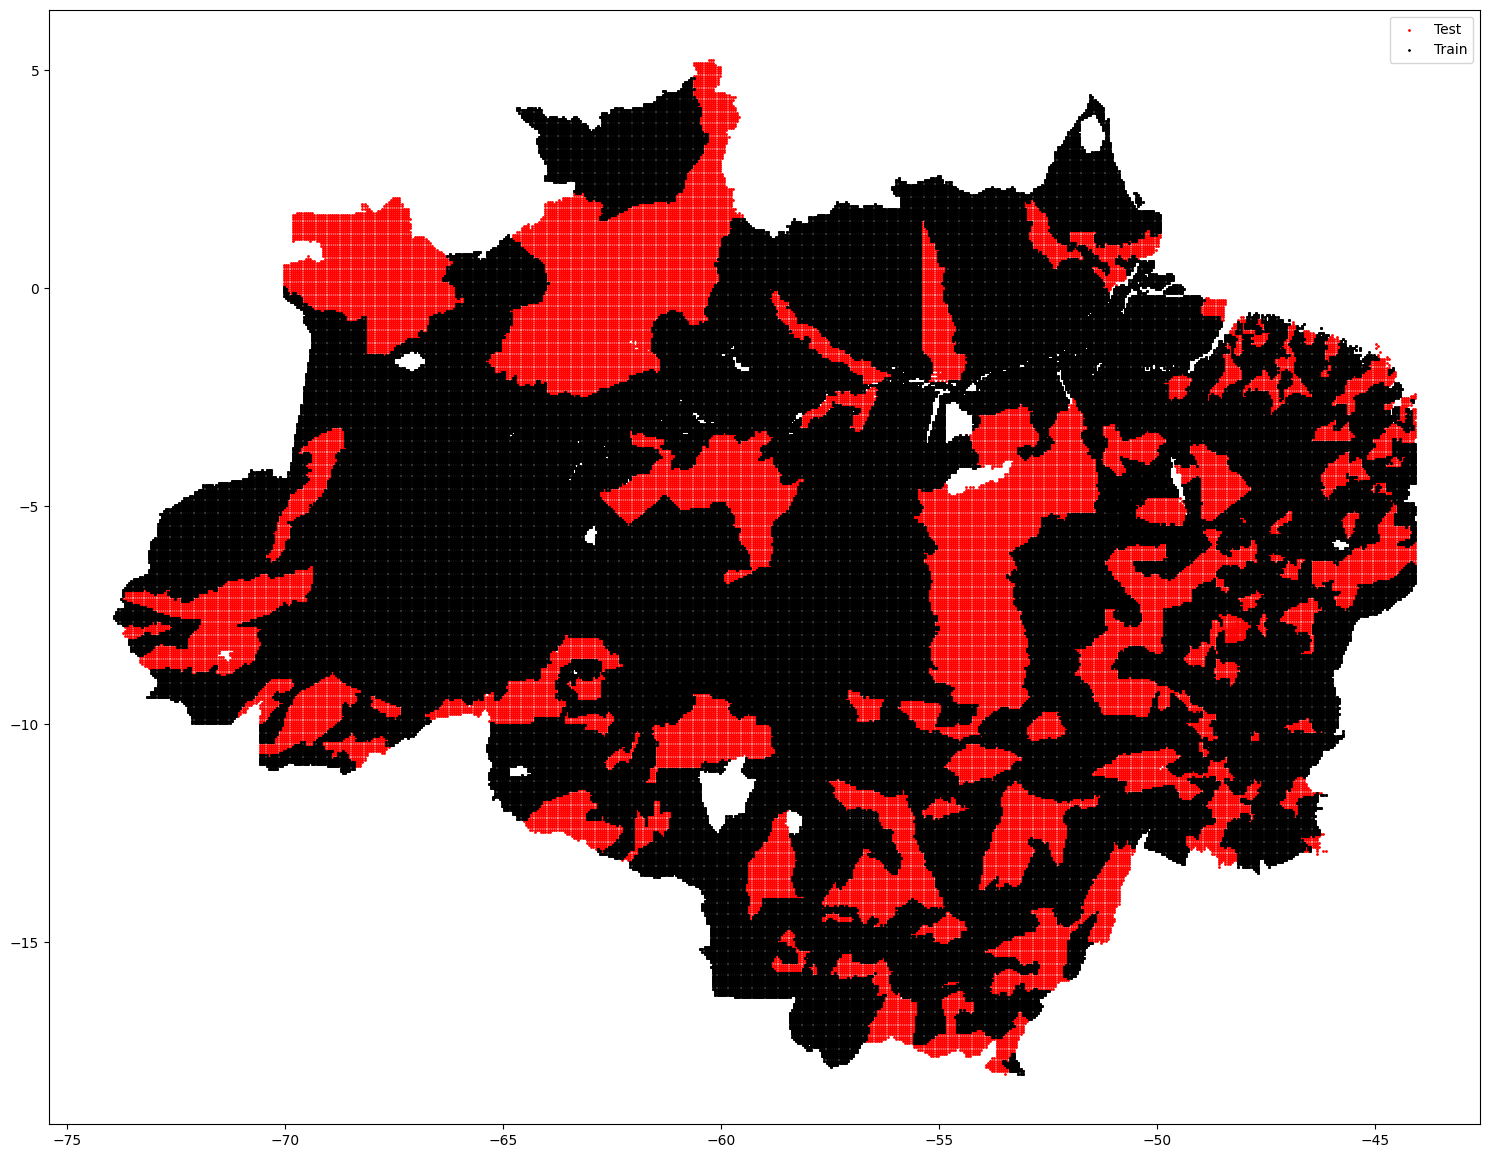

100%|██████████| 1/1 [00:19<00:00, 19.12s/it]

New cross validation indices generated and read in


In [4]:
first_time = True

for this_start_year in tqdm([2004]):
    SUBSET = False
    SUBSET_SIZE = 100000

    if first_time: 
        NEW_INDICES = True
        NEW_CV_INDICES = True
        #first_time = False
        print('Set to create new indices for test train split and cross validation')
    else: 
        NEW_INDICES = False
        NEW_CV_INDICES = False
        print('Reading previous iteration test train split indices and cross validation indices')
    

    PLOT_ENTIRE_AREA = True
    PLOT_FOLDS = False

    START_YEAR_TRAIN = this_start_year
    NUMBER_YEARS_TRAIN = 3
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + i  for i in range(NUMBER_YEARS_TRAIN + 1)]

    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN

    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + i}_' for i in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'

    FILE_PATH = f'FeatureImportanceResults/{FOLDER_NAME}/'

    print(f'Starting fit for {this_start_year}')

    setup_directory(FOLDER_NAME)
    
    df_full = get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN)
    
    if SUBSET:
        df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)

    X, Y = split_XY(df_full)

    if NEW_INDICES:
        train_inds, test_inds = get_new_test_train_inds(X, Y, df_full, FOLDER_NAME)
    if not NEW_INDICES:
        train_inds, test_inds = get_prev_test_train_inds(FOLDER_NAME)

    X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME)

    if NEW_CV_INDICES:
        muni_cv = get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR, FILE_PATH)
    if not NEW_CV_INDICES:
        muni_cv = get_prev_cv(FOLDER_NAME)

    #get_null_count(X_train, FOLDER_NAME)
            
    #X_train = X_train.drop('geometry', axis = 1)
    #X_test = X_test.drop('geometry', axis = 1)

    #random forest
    #randomforest_features_df = train_random_forest(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #lasso 
    #lasso_features_df = train_lasso(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #gradient boosting
    #gradient_boosting_features_df = train_gradient_boost(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)
    
    #neural network
    nn_features_df = train_neural_network(X_train, Y_train, X_test, Y_test, FILE_PATH, FOLDER_NAME, muni_cv)

    #super learner ensemble
    #base_learners = get_base_learners(FOLDER_NAME)
    #super_learner_features_df = train_super_learner(X_train, Y_train, X_test, Y_test, FILE_PATH, muni_cv, base_learners, FOLDER_NAME)

    #visualize
    #yhat_list = get_yhat_list(FOLDER_NAME)
    #visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)
    

In [6]:
pipeline = Pipeline([
                ('scaler',StandardScaler()),
                ('model', MLPRegressor(activation = 'logistic', random_state=42))
])
param_grid = {'model__hidden_layer_sizes':[(50,),(100,)], 'model__alpha':np.arange(0.00001, 0.001, 0.001)}
cv = muni_cv

In [7]:
# Perform grid search with parallelization
results = Parallel(n_jobs=-2, verbose=10)(
    delayed(grid_search_fit)(pipeline, param_grid, cv, X_train, Y_train)
    for _ in range(10)
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/annieulichney/.local/share/virtualenvs/annieulichney-xxpO7m7Z/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.re

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  20.7s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  22.1s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  22.2s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  22.3s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,)

[Parallel(n_jobs=-2)]: Done   3 out of  10 | elapsed:  4.6min remaining: 10.7min
[Parallel(n_jobs=-2)]: Done   5 out of  10 | elapsed:  4.6min remaining:  4.6min
[Parallel(n_jobs=-2)]: Done   7 out of  10 | elapsed:  4.6min remaining:  2.0min


[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.003 total time=  12.4s
[CV 2/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.000 total time=  11.8s
[CV 3/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.002 total time=  12.6s
[CV 4/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.001 total time=  12.8s
[CV 5/5] END model__alpha=1e-05, model__hidden_layer_sizes=(50,);, score=-0.001 total time=  11.7s
[CV 1/5] END model__alpha=1e-05, model__hidden_layer_sizes=(100,);, score=-0.001 total time=  17.5s
[CV 2/5] END model__alpha=1e-05, model__hidden_layer_sizes=(100,);, score=-0.001 total time=  17.5s
[CV 3/5] END model__alpha=1e-05, model__hidden_layer_sizes=(100,);, score=-0.001 total time=  17.5s
[CV 4/5] END model__alpha=1e-05, model__hidden_layer_sizes=(100,);, score=-0.002 total time=  17.2s
[CV 5/5] END model__alpha=1e-05, model__hidden_layer_sizes=(100,);, score=-0.001 total time=  17.9s


[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:  7.4min finished


In [8]:
best_model = max(results, key=lambda x: x["best_score"])["model"]

In [9]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPRegressor(activation='logistic', alpha=1e-05,
                              random_state=42))])

In [17]:
explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train, 250), nsamples = 100)

X does not have valid feature names, but StandardScaler was fitted with feature names
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
